In [1]:
# load subject_class to use
# %load subject_class.py
from __future__ import print_function, division
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import re

class subject(object):
    """try to organize data based on subject ex sub001"""
    def __init__(self,sub):
        # subject info ex: 'sub001'
        self.sub_id = sub

        # BOLD folder for this subject
        sub_BOLD_path = "../data/ds105/%s/BOLD/" %self.sub_id

        # anatomy folder for this subject
        sub_anatomy_file = "../data/ds105/%s/anatomy/highres001_brain.nii.gz" %self.sub_id
        
        # runfile_list: ['task001_run001', 'task001_run002'......]
        runfile_list = ['task001_run'+ i+ '.txt' for i in ['001','002','003','004','005','006','007','008','009','010','011','012']]
        runlist = ['run'+ i for i in ['001','002','003','004','005','006','007','008','009','010','011','012']]
        
        # TR info:
        self.TR = 2.5
        
        # load high resolution brain structure for this subject
        self.brain_img = nib.load(sub_anatomy_file)
        
        # load all bold image file for this subject
        self.run_img_result = {}
        for i in runlist:
            self.run_img_result[self.sub_id + '_' + i] = nib.load(sub_BOLD_path+'task001_'+i+'/bold.nii.gz')
        
        # all run keys:
        self.run_keys = self.run_img_result.keys()

        # shape of the BOLD data:
        self.BOLD_shape = self.run_img_result[self.run_keys[1]].shape
        
        # conditions setting: which condition is for which category
        self.condition_key_file = open("../data/ds105/models/model001/condition_key.txt")
        condition_list = self.condition_key_file.readlines()
        condition = re.compile(r'(cond\d+) (\w+)')
        result = {}
        for item in condition_list:
            for match in condition.finditer(item):
                result[match.group(1)] = match.group(2)
        self.condition_key = result
        
        # condition files for each objects for each run
        sub_condition_path = "../data/ds105/%s/model/model001/onsets/" %self.sub_id
        self.conditions = {}
        for i in runfile_list:
            for j in self.condition_key.keys():
                self.conditions[i[8:14]+'-'+self.condition_key[j]] = sub_condition_path + i[:-4]+'/'+j+'.txt'
                   
                



In [2]:
# focus on subject 001
sub= subject("sub001")

In [3]:
# get all image data for subject 001
img = sub.run_img_result

In [4]:
# check keys for all runs
img.keys()

['sub001_run012',
 'sub001_run006',
 'sub001_run007',
 'sub001_run004',
 'sub001_run005',
 'sub001_run002',
 'sub001_run003',
 'sub001_run001',
 'sub001_run010',
 'sub001_run011',
 'sub001_run008',
 'sub001_run009']

In [5]:
# load the diagnostics.py from homework2
# %load diagnostics.py
""" Diagnostics.py

A collection of utility functions for diagnostics on FMRI data

See test_* functions in this directory for nose tests
"""
# import important library

from __future__ import division, print_function, absolute_import
import numpy as np
import nibabel as nib

def vol_std(data):
    """ Return standard deviation across voxels for 4D array `data`

    Parameters
    ----------
    data : 4D array
        4D array from FMRI run with last axis indexing volumes.  Call the shape
        of this array (M, N, P, T) where T is the number of volumes.

    Returns
    -------
    std_values : array shape (T,)
        One dimensonal array where ``std_values[i]`` gives the standard
        deviation of all voxels contained in ``data[..., i]``.
    """

    result = [0] * data.shape[-1]
    for i in range(len(result)):
        result[i] = np.std(data[:,:,:,i])
    return result


def iqr_outliers(arr_1d, iqr_scale=1.5):
    """ Return indices of outliers identified by interquartile range

    Parameters
    ----------
    arr_1d : 1D array
        One-dimensional numpy array, from which we will identify outlier
        values.
    iqr_scale : float, optional
        Scaling for IQR to set low and high thresholds.  Low threshold is given
        by 25th centile value minus ``iqr_scale * IQR``, and high threshold id
        given by 75 centile value plus ``iqr_scale * IQR``.

    Returns
    -------
    outlier_indices : array
        Array containing indices in `arr_1d` that contain outlier values.
    lo_hi_thresh : tuple
        Tuple containing 2 values (low threshold, high thresold) as described
        above.
    """
    # Hint : np.lookfor('centile')
    # Hint : np.lookfor('nonzero')
    
    # get parameters
    IQR = np.percentile(arr_1d, 75) - np.percentile(arr_1d, 25)
    lo_thresh = np.percentile(arr_1d, 25) - IQR * iqr_scale
    hi_thresh = np.percentile(arr_1d, 75) + IQR * iqr_scale
    
    # find outlier_indeces
    outlier_indices = []
    for index in range(len(arr_1d)):
        if arr_1d[index] < lo_thresh or arr_1d[index] > hi_thresh:
            outlier_indices.append(index)
    return (outlier_indices, (lo_thresh, hi_thresh))
    

def vol_rms_diff(arr_4d):
    """ Return root mean square of differences between sequential volumes

    Parameters
    ----------
    data : 4D array
        4D array from FMRI run with last axis indexing volumes.  Call the shape
        of this array (M, N, P, T) where T is the number of volumes.

    Returns
    -------
    rms_values : array shape (T-1,)
        One dimensonal array where ``rms_values[i]`` gives the square root of
        the mean (across voxels) of the squared difference between volume i and
        volume i + 1.
    """
    
    time_length = arr_4d.shape[-1]
    diff_vol = []
    for item in range(time_length -1):
        diff_vol.append(arr_4d[...,item+1] - arr_4d[...,item])
    rms_values = []
    for i in diff_vol:
        rms_values.append(np.sqrt(np.mean(i**2)))
   
    return rms_values


def extend_diff_outliers(diff_indices):
    """ Extend difference-based outlier indices `diff_indices` by pairing

    Parameters
    ----------
    diff_indices : array
        Array of indices of differences that have been detected as outliers.  A
        difference index of ``i`` refers to the difference between volume ``i``
        and volume ``i + 1``.

    Returns
    -------
    extended_indices : array
        Array where each index ``j`` in `diff_indices has been replaced by two
        indices, ``j`` and ``j+1``, unless ``j+1`` is present in
        ``diff_indices``.  For example, if the input was ``[3, 7, 8, 12, 20]``,
        ``[3, 4, 7, 8, 9, 12, 13, 20, 21]``.
    """

    extended_indices = []
    for item in diff_indices:
        if item not in extended_indices:
            extended_indices.append(item)
        if (item+1) not in extended_indices:
            extended_indices.append(item+1)
    
    return extended_indices




In [6]:
# load matplotlib
%matplotlib inline

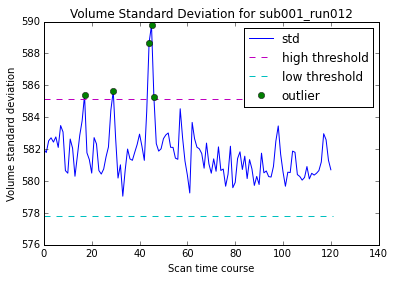

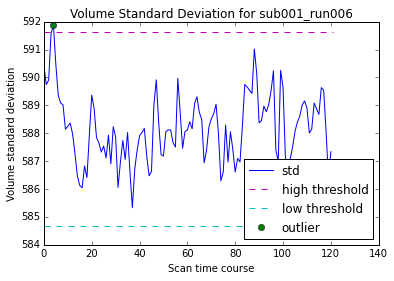

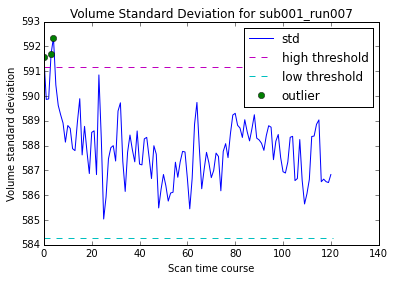

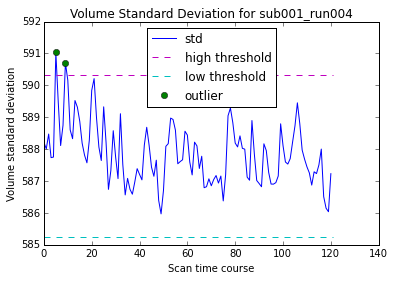

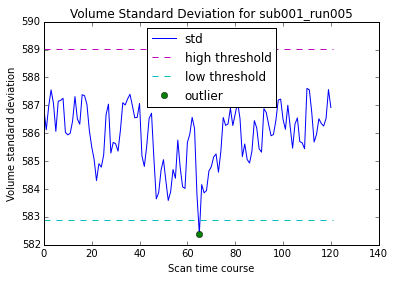

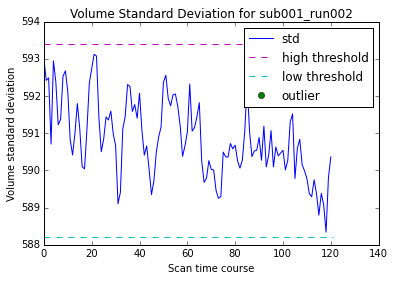

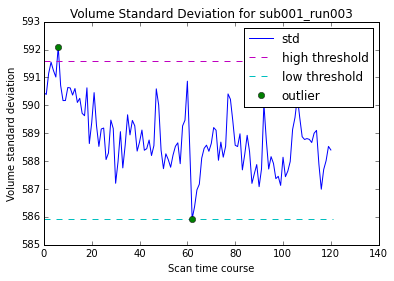

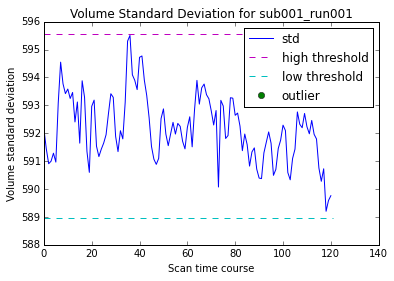

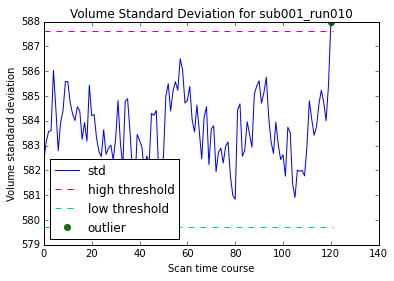

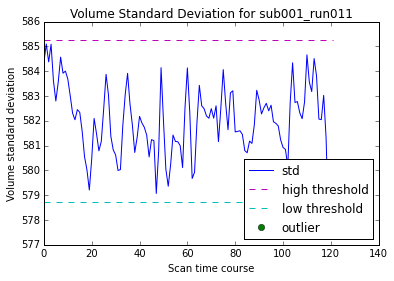

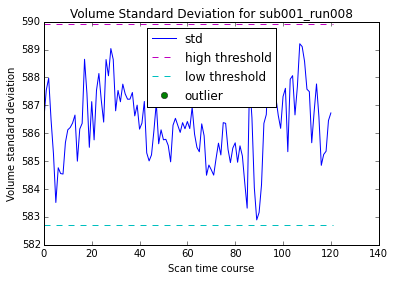

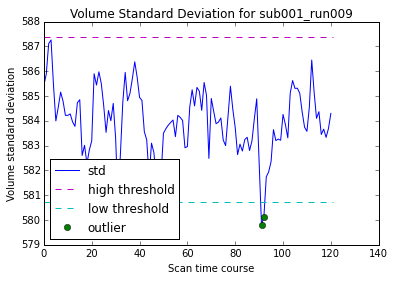

In [7]:
# check outliers for all 12 runs for subject 001

for key, imgresult in img.iteritems():
    data = imgresult.get_data()
    v_std = vol_std(data)
    outlier_indices, thresh = iqr_outliers(v_std)
    y_value = [v_std[i] for i in outlier_indices]
    plt.figure()
    plt.plot(v_std, label = 'std')
    plt.plot([0,len(v_std)],[thresh[1],thresh[1]], "k--",\
    label = 'high threshold', color='m')
    plt.plot([0,len(v_std)],[thresh[0],thresh[0]], "k--",\
    label = 'low threshold', color='c')
    plt.plot(outlier_indices, y_value, 'o', color = 'g', label = 'outlier')
    plt.xlabel('Scan time course')
    plt.ylabel('Volume standard deviation')
    plt.title('Volume Standard Deviation for %s'%key)
    plt.legend(loc = 0, numpoints = 1)

In [8]:
# load high resolusion brain scan for subject 001
brain = sub.brain_img

In [9]:
# shape of high resolution brain scan
brain.shape

(124, 256, 256)

In [10]:
# shape of BOLD scan
sub.BOLD_shape

(40, 64, 64, 121)

In [11]:
# affine of sub001_run001
img['sub001_run001'].affine

array([[  -3.5  ,    0.   ,    0.   ,   68.25 ],
       [   0.   ,    3.75 ,    0.   , -118.125],
       [   0.   ,    0.   ,    3.75 , -118.125],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

In [12]:
# affine of high resolution brain scan
# Not sure how to use thses affine -> need to ask Matthew
brain.affine

array([[  -1.20000005,    0.        ,    0.        ,   73.80000293],
       [   0.        ,    0.9375    ,    0.        , -119.53125   ],
       [   0.        ,    0.        ,    0.9375    , -119.53125   ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [13]:
# get data of high resolution brain scan
brain_data = brain.get_data()

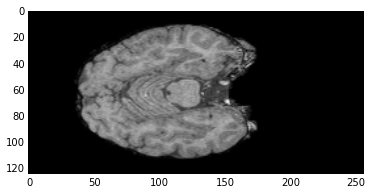

In [14]:
# this might be the section that is used in the paper
plt.imshow(brain_data[:,:,104],cmap = "gray")

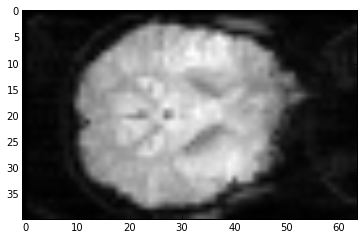

In [15]:
# try to choose z-value = 32 for following test analysis
plt.imshow(data[:,:,32,30],cmap = "gray")

In [16]:
# %load get_object_neural.py

def get_object_neural(sub_ID ,condition_dict, object_name, TR, n_vox, check = 0, ):
    """
    get object neural array for specific object from all runs, odd runs or even runs
    
    parameters
    ----------
    condition_dict: dictionary of all condition files
    object_name: desired object name: 'house','scrambledpix','cat','shoe','bottle','scissors','chair','face'
    TR: TR for fMRI
    n_vox: time course of fMRI
    check: 1= odd runs, 2=even runs, others = all runs
    
    output
    -------
    a dictionary of run name : (neural array, path of the bold image) for that run
    ex:
    
    {
    'run001-bottle-neural': (array([ 0.,  0.,  0.,  0.,  0., ...]), bold path)
    'run002-bottle-neural': (array([ 0.,  0.,  0.,  0.,  0., ...]), bold path)
    }
    
    
    """
    # check if the object name is valid
    valid_object =["house","scrambledpix","cat","shoe","bottle","scissors","chair","face"]
    assert (object_name in valid_object)
    
    condition_dict_key = condition_dict.keys()
    result = {}
    for i in condition_dict_key:
        if check == 1:
            if object_name in i:
                if int(i[3:6])%2 ==1:
                    result[i+'-neural'] = (events2neural(condition_dict[i], TR, n_vox), "../data/ds105/%s/BOLD/task001_"% sub_ID + i[:6]+"/bold.nii.gz")
        elif check == 2:
            if object_name in i: 
                if int(i[3:6])%2 ==0:
                    result[i+'-neural'] = (events2neural(condition_dict[i], TR, n_vox), "../data/ds105/%s/BOLD/task001_"% sub_ID + i[:6]+"/bold.nii.gz")
        else:
            if object_name in i:
                result[i+'-neural'] = (events2neural(condition_dict[i], TR, n_vox), "../data/ds105/%s/BOLD/task001_"%sub_ID + i[:6]+"/bold.nii.gz")
        
    
    return result




In [17]:
# import events2neural
from stimuli import events2neural

In [18]:
# %load ObtainData.py
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

def pull3D(DictionaryOfVectors):
	Three_D_Data = []
	for key, value in DictionaryOfVectors.iteritems():
		vector = value[0]
		fileLocation = value[1]
		img = nib.load(fileLocation)
		data = img.get_data()
		for i in range(0, len(vector)):
			if vector[i] == 1:
				Three_D_Data.append(data[:, :, :, i])
	return Three_D_Data

def ShowCortex(ListOf3dImages):
	for image in ListOf3dImages:
		zDimension = np.shape(image)[2]
		for i in range(0, zDimension):
			plt.imshow(image[:, :, i], cmap = "gray")
			plt.show()

# You'll have to guess the Z value from the images show in the previous function
def generateEvenlySpacedZpoints(zValue):
	return np.linspace(start = 0, stop = zValue, num = zValue)

In [19]:
# modify the pull3D to return a matrix
def newpull3D(DictionaryOfVectors):
    addup = 0
    for i in DictionaryOfVectors.keys():
        addup += np.sum(DictionaryOfVectors[i][0])
    Three_D_Data = np.zeros((40,64,64,addup))
    
    for key, value in DictionaryOfVectors.iteritems():
        vector = value[0]
        fileLocation = value[1]
        img = nib.load(fileLocation)
        data = img.get_data()
        check4D = 0
        for i in range(0, len(vector)):
            if vector[i] == 1:
                Three_D_Data[:,:,:,check4D] = data[:, :, :, i]
                check4D += 1
                
    return Three_D_Data

In [20]:
# get odd and even run neural result for each objects
odd_chair = get_object_neural(sub.sub_id, sub.conditions,"chair",sub.TR,sub.BOLD_shape[-1], check = 1)
even_chair = get_object_neural(sub.sub_id, sub.conditions,"chair",sub.TR,sub.BOLD_shape[-1], check = 2)
odd_shoe = get_object_neural(sub.sub_id, sub.conditions,"shoe",sub.TR,sub.BOLD_shape[-1],check =1)
even_shoe = get_object_neural(sub.sub_id, sub.conditions,"shoe",sub.TR,sub.BOLD_shape[-1], check =2)
odd_face = get_object_neural(sub.sub_id, sub.conditions,"face",sub.TR,sub.BOLD_shape[-1],check=1)
even_face = get_object_neural(sub.sub_id, sub.conditions,"face",sub.TR,sub.BOLD_shape[-1], check=2)
odd_cat = get_object_neural(sub.sub_id, sub.conditions,"cat",sub.TR,sub.BOLD_shape[-1],check=1)
even_cat = get_object_neural(sub.sub_id, sub.conditions,"cat",sub.TR,sub.BOLD_shape[-1],check=2)
odd_bottle = get_object_neural(sub.sub_id, sub.conditions,"bottle",sub.TR,sub.BOLD_shape[-1],check=1)
even_bottle = get_object_neural(sub.sub_id, sub.conditions,"bottle",sub.TR,sub.BOLD_shape[-1],check=2)
odd_house = get_object_neural(sub.sub_id, sub.conditions,"house",sub.TR,sub.BOLD_shape[-1],check=1)
even_house = get_object_neural(sub.sub_id, sub.conditions,"house",sub.TR,sub.BOLD_shape[-1],check=2)
odd_scissors = get_object_neural(sub.sub_id, sub.conditions,"scissors",sub.TR,sub.BOLD_shape[-1],check=1)
even_scissors = get_object_neural(sub.sub_id, sub.conditions,"scissors",sub.TR,sub.BOLD_shape[-1],check=2)
odd_scrambledpix = get_object_neural(sub.sub_id, sub.conditions,"scrambledpix",sub.TR,sub.BOLD_shape[-1],check=1)
even_scrambledpix = get_object_neural(sub.sub_id, sub.conditions,"scrambledpix",sub.TR,sub.BOLD_shape[-1],check=2)

In [21]:
# get meaningful slices for each objects from odd or even runs
m_odd_chair = newpull3D(odd_chair)
m_even_chair = newpull3D(even_chair)
m_odd_shoe = newpull3D(odd_shoe)
m_even_shoe = newpull3D(even_shoe)
m_odd_house = newpull3D(odd_house)
m_even_house = newpull3D(even_house)
m_odd_scrambledpix = newpull3D(odd_scrambledpix)
m_even_scrambledpix = newpull3D(even_scrambledpix)
m_odd_cat = newpull3D(odd_cat)
m_even_cat = newpull3D(even_cat)
m_odd_bottle = newpull3D(odd_bottle)
m_even_bottle = newpull3D(even_bottle)
m_odd_scissors = newpull3D(odd_scissors)
m_even_scissors = newpull3D(even_scissors)
m_odd_face = newpull3D(odd_face)
m_even_face = newpull3D(even_face)

In [22]:
# double check the shape, it shoud be 40x64x64x how many meaningful results
m_odd_house.shape

(40, 64, 64, 16)

In [23]:
# pick face and house for analysis
# take means of meaningful results to get 3D matrix

mean_odd_face = np.mean(m_odd_face, axis =3)
mean_even_face = np.mean(m_even_face, axis =3)
mean_odd_house = np.mean(m_odd_house, axis =3)
mean_even_house = np.mean(m_even_house, axis =3)


In [24]:
# take slice at z=32 for analysis:
zslice_mean_odd_face = mean_odd_face[:,:,32]
zslice_mean_even_face = mean_even_face[:,:,32]
zslice_mean_odd_house = mean_odd_house[:,:,32]
zslice_mean_even_house = mean_even_house[:,:,32]


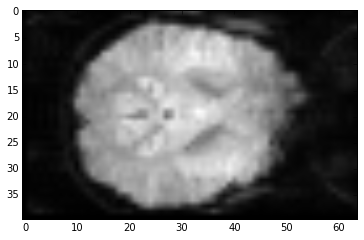

In [25]:
# show figure of odd face and even house
# but it doesn't seem to have any differences....
plt.imshow(zslice_mean_odd_face,cmap = "gray")

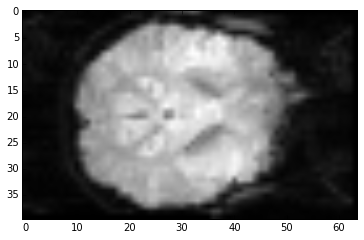

In [26]:
plt.imshow(zslice_mean_even_house,cmap = "gray")

In [27]:
# ttest for two result
# may need to use result before taking mean for better ttest?
import scipy.stats

In [28]:
t,p = scipy.stats.ttest_ind(zslice_mean_odd_face, zslice_mean_even_house, equal_var= False)

In [29]:
p

array([  2.49024635e-10,   8.15206203e-01,   2.45810815e-01,
         2.96291172e-01,   5.95619097e-02,   1.71949119e-01,
         1.52436006e-01,   4.58256156e-01,   4.60441451e-01,
         9.39698852e-01,   8.03610357e-01,   8.00245796e-01,
         7.73026059e-01,   7.10064734e-01,   6.57090039e-01,
         6.16298917e-01,   7.36379996e-01,   7.61391341e-01,
         7.86348466e-01,   6.44194532e-01,   6.42074164e-01,
         5.89359084e-01,   5.81063052e-01,   5.04177306e-01,
         4.73600281e-01,   3.84792910e-01,   4.49139469e-01,
         4.26664772e-01,   4.66804622e-01,   4.52658829e-01,
         4.29981088e-01,   5.94210550e-01,   6.26177024e-01,
         4.91143822e-01,   5.76850459e-01,   5.41552642e-01,
         5.03988795e-01,   4.31205060e-01,   4.61276000e-01,
         5.75330363e-01,   5.33565079e-01,   5.77145091e-01,
         5.69754625e-01,   5.13134734e-01,   5.63728771e-01,
         6.29433928e-01,   8.28747704e-01,   9.09895124e-01,
         7.10227952e-01,

In [30]:
# compare between face and house result:
# potential outliers?
face_to_house = zslice_mean_odd_face - zslice_mean_even_house

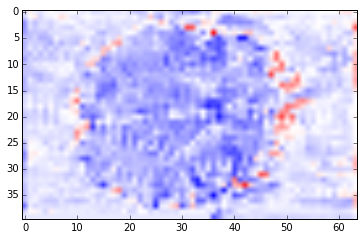

In [31]:
plt.imshow(face_to_house,cmap = "bwr")

In [32]:
house_to_face = zslice_mean_even_house - zslice_mean_odd_face

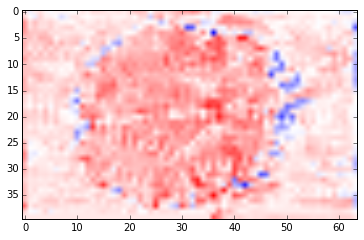

In [33]:
plt.imshow(house_to_face,cmap = "bwr")

In [34]:
# check correlation

In [35]:
corr_in_face = np.corrcoef(zslice_mean_even_face, zslice_mean_odd_face)

/Users/tzuchieh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/lib/function_base.py:1957: RuntimeWarning: invalid value encountered in true_divide
  return c / sqrt(multiply.outer(d, d))


In [36]:
corr_in_face

array([[  1.00000000e+00,   1.09623890e-01,   1.19244472e-01, ...,
          6.17264979e-01,   4.43016230e-04,              nan],
       [  1.09623890e-01,   1.00000000e+00,   7.31200873e-01, ...,
          1.80398775e-01,   4.25645459e-01,              nan],
       [  1.19244472e-01,   7.31200873e-01,   1.00000000e+00, ...,
          3.68433596e-01,   1.35878651e-01,              nan],
       ..., 
       [  6.17264979e-01,   1.80398775e-01,   3.68433596e-01, ...,
          1.00000000e+00,   1.47375992e-01,              nan],
       [  4.43016230e-04,   4.25645459e-01,   1.35878651e-01, ...,
          1.47375992e-01,   1.00000000e+00,              nan],
       [             nan,              nan,              nan, ...,
                     nan,              nan,              nan]])

In [37]:
# there are seom nan...
# I only go so far here...